In [69]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
g_train_iter, g_test_iter = d2l.load_data_fashion_mnist(batch_size)

In [70]:
num_inputs = 28 * 28
num_outputs = 10

g_W = torch.normal(0, .01, size=(num_inputs, num_outputs), requires_grad=True)
g_b = torch.zeros(num_outputs, requires_grad=True)

In [71]:
def softmax(X):
    X_exp = torch.exp(X)
    sum_val = X_exp.sum(1, keepdims = True)

    return X_exp / sum_val

In [72]:
def model(X):
    return softmax(torch.matmul(X.reshape((-1, g_W.shape[0])), g_W) + g_b)

In [73]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

In [74]:
def accuracy(y_hat, y):
    # 获取概率最大的一个
    if (len(y_hat.shape) > 1 and y_hat.shape[1] > 1):
        y_hat = y_hat.argmax(axis=1)

    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [75]:
class Accumulator:
    # 在n个变量上累加
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [76]:
def evaluate(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()

    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [77]:
def train_model(model, train_iter, loss, optimizer):
    if isinstance(model, torch.nn.Module):
        model.train()

    metric = Accumulator(3)
    for X, y in train_iter:

        y_hat = model(X)
        l = loss(y_hat, y)
        if isinstance(optimizer, torch.optim.Optimizer):
            optimizer.zero_grad()
            l.mean().backward()
            optimizer.step()
            
        else:
            l.sum().backward()
            optimizer(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    return metric[0] / metric[2], metric[1] / metric[2]

In [78]:
g_lr = .1

def optimizer(batch_size):
    return d2l.sgd([g_W, g_b], g_lr, batch_size)

In [ ]:
g_test_accurates = []

def train(model, train_iter, test_iter, loss, num_epochs, optimizer):
    for epoch in range(num_epochs):
        train_mertics = train_model(model, train_iter, loss, optimizer)
        g_test_accurates.append(evaluate(model, test_iter))

In [80]:
train(model, g_train_iter, g_test_iter, cross_entropy, 3, optimizer)

ValueError: x and y must have same first dimension, but have shapes (3,) and (0,)

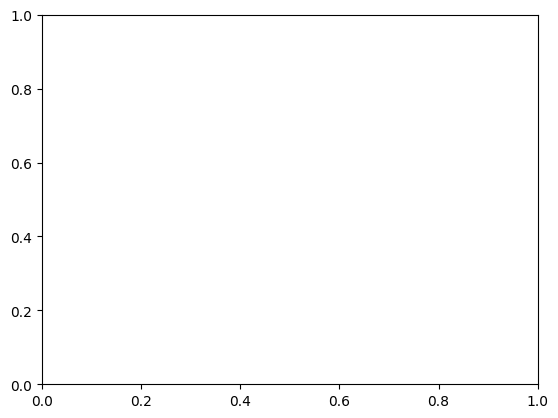

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, 4), g_test_accurates)
plt.ylabel("accuracy")
plt.xlabel("epochs")

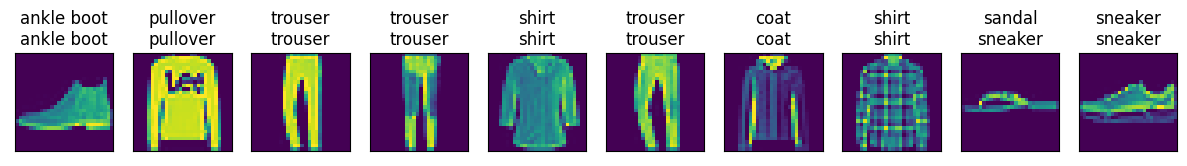

In [ ]:
def predict(model, test_iter, n = 10):
    X, y = next(iter(test_iter))

    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(model(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
    
predict(model, test_iter)

**高级API实现**

In [84]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [85]:
model = nn.Sequential(nn.Flatten(), nn.Linear(28 * 28, 10))

def init_weights(model):
    if type(model) == nn.Linear:
        nn.init.normal_(model.weight, std=.01)

model.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [86]:
loss = nn.CrossEntropyLoss(reduce="none")
trainer = torch.optim.SGD(model.parameters(), lr=.01)

d:\Anaconda\envs\d2l\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [87]:
train(model, train_iter, test_iter, loss, 10, trainer)

ValueError: x and y must have same first dimension, but have shapes (3,) and (0,)

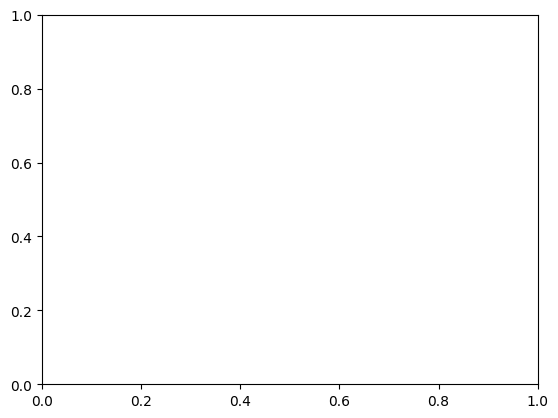

In [88]:
plt.plot(range(1, 4), g_test_accurates)
plt.ylabel("accuracy")
plt.xlabel("epochs")